## CSV to parquet 

#### idea:
1. convert from csv to parquet
   - keep the description -> how? -> look for 
   - delete csv afterwards
2. adapt ASCII optimized code for parquet reading

#### remarks/differences to ASCII code:
- Column names are different

In [22]:
import pandas as pd
import argparse
import pyarrow as pa
import pyarrow.parquet as pq
import os
import time 

### finalized Parquet writer below

In [ ]:
def csv_to_parquet(csv_file : str,parquet_file : str, chunksize=100_000_000):
    try:
        # Split description and stream the data in chunks
        with open(csv_file, "r", encoding='utf-8') as f:

            clock_start = time.perf_counter()
            
            # Read and store comment block
            description_lines = []
            pos = f.tell()
            line = f.readline()
            while line and line.lstrip().startswith("//"):
                description_lines.append(line.rstrip("\n"))
                pos = f.tell()
                line = f.readline()
            f.seek(pos)  # rewind to header row
            

            # initialize parquet writer 
            writer = None
            col_names = ['Tstamp_us', 'Trg_Id', 'Entries', 'Brd', 'Ch', 'ToA_ns', 'ToT_ns','Edge'] # adjusts column names and drops 'Edge'
            for i, chunk in enumerate(pd.read_csv(f, chunksize=chunksize, header=0, names=col_names)):  # chunked iteration
                table = pa.Table.from_pandas(chunk.drop(columns=['Edge']), preserve_index=False)
                print(f'Converting chunk: {i+1}')
                
                if writer is None:
                    # Attach metadata only once on first write
                    meta = dict(table.schema.metadata or {})
                    meta[b"file_description"] = "\n".join(description_lines).encode("utf-8")  
                    table = table.replace_schema_metadata(meta)
                    writer = pq.ParquetWriter(parquet_file, table.schema)  
                writer.write_table(table)
                
            if writer is not None:
                writer.close()
                time_diff = time.perf_counter() - clock_start
                print(f'finished writing parquet file to: {parquet_file}')
                print(f'Total time to run code is: {time_diff}')

                

    
    except Exception as e:
        print(f"Error: {e}")
        return None
        
if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="Convert large CSV to Parquet in chunks")
    parser.add_argument("csv_file", help="Path to input CSV file")
    parser.add_argument("parquet_file", help="Path to output Parquet file")
    parser.add_argument("--chunksize", type=int, default=10000000, help="Number of rows per chunk (default: 10,000,000)")
    args = parser.parse_args()

    if os.path.exists(args.parquet_file):
        os.remove(args.parquet_file)  # Avoid appending to old file

    csv_to_parquet_chunked(args.csv_file, args.parquet_file, args.chunksize)

In [ ]:
csv_to_parquet('data/test_signal_Run699_list.csv', 'test.parquet')

In [ ]:
db = pd.read_parquet('backgrnd_Run702.parquet')
db.head()

In [ ]:
db.dtypes

In [ ]:
from code_for_ASCII.big_histograms import TDC_ToT_histograms

#### adapt ASCII analysis codes for parquet file 

In [ ]:
TDC_ToT_histograms('signal_Run699.parquet') # creates mistake for parquet 

In [ ]:
df = pd.read_csv('data/test_signal_Run699_list.csv', comment='/') # ignores rows starting with /
list(df.columns)

### code for compatibility across all datatypes:

In [ ]:
def histograms_txt_csv(file, num_bins=135, chunksize = 10_000_000, tot_range = (1.7,3.2), toa_range = (0, 250)):
    # plt style
    plt.style.use('ggplot')
    plt.rcParams['text.usetex']=False

    print('Accumulating histograms in chunks...')
    
    # ToT bin edges 
    bin_edges_tot = np.linspace(tot_range[0], tot_range[1], num_bins + 1)
    hist_sig_tot = np.zeros(num_bins, dtype=int)
    hist_bkgrnd_tot = np.zeros(num_bins, dtype=int)

    # deltaT bin edges 
    bin_edges_toa = np.linspace(delta_range[0], delta_range[1], num_bins + 1)
    hist_sig_toa= np.zeros(num_bins, dtype=int)
    hist_bkgrnd_toa = np.zeros(num_bins, dtype=int)

    
def histograms_parquet(file, num_bins=135, chunksize = 10_000_000, tot_range = (1.7,3.2), toa_range = (0, 250)):
    # plt style
    plt.style.use('ggplot')
    plt.rcParams['text.usetex']=False

    print('Accumulating histograms in chunks...')
    
    # ToT bin edges 
    bin_edges_tot = np.linspace(tot_range[0], tot_range[1], num_bins + 1)
    hist_sig_tot = np.zeros(num_bins, dtype=int)
    hist_bkgrnd_tot = np.zeros(num_bins, dtype=int)

    # deltaT bin edges 
    bin_edges_toa = np.linspace(delta_range[0], delta_range[1], num_bins + 1)
    hist_sig_toa= np.zeros(num_bins, dtype=int)
    hist_bkgrnd_toa = np.zeros(num_bins, dtype=int)



def compatible_histograms(file):
    
    colummn_names = ['Tstamp_us', 'Trg_Id', 'Entries', 'Brd', 'Ch', 'ToA_ns', 'ToT_ns', 'Edge']
    
    # check file type and separate standard from .parquet
    if os.path.isfile(file):
        ext = os.path.splitext(file)[1].lower()
        if ext in {'.parquet', '.csv', '.txt'}:
            print(f'Correct file type {ext} has been put in...')
    
            
            if ext in {'.csv', '.txt'}:
                df = pd.read_csv(file, skipinitialspace=True, comment='/', nrows=1000)
                print(f'The column names of this file type are: {list(df.columns)}...')
                ### maybe add here something that checks if the column names are the same in all dataframes -> in ASCII the columns are different
                    
            if ext == '.parquet':
                df = pd.read_parquet(file, skipinitialspace=True, )
    
        else:
            print(f'The file type is incorrect. File type is: {ext}')
       
    

In [ ]:
def TDC_ToT_histograms(datafile, chunksize=10_000_000, num_bins=135, tot_range=(1.7, 3.2), delta_range=(0, 250)):
    """ Plots ToT histograms of both channels in chunks (memory safe).
    """
    try:
        
        ###plt style
        plt.style.use('ggplot')
        plt.rcParams['text.usetex']=False
        
        # ToT bin edges
        bin_edges_tot = np.linspace(tot_range[0], tot_range[1], num_bins + 1)
        hist_sig_tot = np.zeros(num_bins, dtype=int)
        hist_bkgrnd_tot = np.zeros(num_bins, dtype=int)

        # deltaT bin edges 
        bin_edges_delta = np.linspace(delta_range[0], delta_range[1], num_bins + 1)
        hist_sig_delta= np.zeros(num_bins, dtype=int)
        hist_bkgrnd_delta = np.zeros(num_bins, dtype=int)
        
        column_names = ['Tstamp_us', 'Trg_Id', 'Brd', 'Ch', 'ToA_ns', 'ToT_ns']

        print("Accumulating histograms in chunks...")
    
            
        reader = pd.read_csv(datafile, delimiter="\t", skiprows=16, names=column_names, skipinitialspace=True, chunksize=chunksize)

        for i, chunk in enumerate(reader):
            print(f"Processing chunk {i+1}...")

            
            # Split by channel
            data_sig_tot = chunk[chunk["Ch"] == 0]['ToT_ns'].dropna()
            data_bkgrnd_tot = chunk[chunk["Ch"] == 1]['ToT_ns'].dropna()
            data_sig_delta = chunk[chunk["Ch"] == 0]['ToA_ns'].dropna()
            data_bkgrnd_delta = chunk[chunk["Ch"] == 1]['ToA_ns'].dropna()
            
            # Update ToT histograms
            h_sig_tot, _ = np.histogram(data_sig_tot, bins=bin_edges_tot)
            h_bkgrnd_tot, _ = np.histogram(data_bkgrnd_tot, bins=bin_edges_tot)
            hist_sig_tot += h_sig_tot
            hist_bkgrnd_tot += h_bkgrnd_tot

            # Update deltaT histograms
            h0_delta, _ = np.histogram(data_sig_delta, bins=bin_edges_delta)
            h1_delta, _ = np.histogram(data_bkgrnd_delta, bins=bin_edges_delta)
            hist_sig_delta += h0_delta
            hist_bkgrnd_delta += h1_delta

            

        # Plot results
        fig, axs = plt.subplots(3, 2, figsize=(12, 10))

        # ToT Histogram for Channel 0
        axs[0, 0].bar(bin_edges_tot[:-1], hist_sig_tot, width=np.diff(bin_edges_tot), align="edge", alpha=0.7, color="blue")
        axs[0, 0].set_title("Channel 0")
        axs[0, 0].set_xlabel("ToT in ns")
        axs[0, 0].set_ylabel("Frequency")

        # ToT Histogram for Channel 1
        axs[0, 1].bar(bin_edges_tot[:-1], hist_bkgrnd_tot, width=np.diff(bin_edges_tot), align="edge", alpha=0.7, color="red")
        axs[0, 1].set_title("Channel 1")
        axs[0, 1].set_xlabel("ToT in ns")

        # deltaT Histogram for Channel 0 
        axs[1,0].bar(bin_edges_delta[:-1], hist_sig_delta, width=np.diff(bin_edges_delta), align='edge', alpha=0.7, color='blue')
        axs[1,0].set_xlabel(r'$\Delta T$ in ns')
        axs[1,0].set_ylabel('Frequency')
        # deltaT Histogram for Channel 1 
        axs[1,1].bar(bin_edges_delta[:-1], hist_bkgrnd_delta, width=np.diff(bin_edges_delta), align='edge', alpha=0.7, color='red')
        axs[1,1].set_xlabel(r'$\Delta T$ in ns')
        
        # Seaborn KDE (approximate, sample only a subset to save memory)
        sample_rows = 1_000_000
        sample_data = pd.read_csv(datafile, delimiter="\t", nrows=sample_rows)
        data0_sample = sample_data[sample_data["Ch"] == 0]["ToT_ns"]
        data1_sample = sample_data[sample_data["Ch"] == 1]["ToT_ns"]

        sns.histplot(data0_sample, bins=num_bins, kde=True, color="blue", ax=axs[2, 0])
        sns.histplot(data1_sample, bins=num_bins, kde=True, color="red", ax=axs[2, 0])
        axs[2, 0].set_title("Approximate ToT distribution (Seaborn KDE)")
        axs[2, 0].set_xlabel("ToT in ns")

        # Hide the empty subplot at bottom right
        fig.delaxes(axs[2, 1])
        '''fig.delaxes(axs[1,0])''' #to cancel KDE approximation
        
        # Overall title
        fig.suptitle(r"ToT and $\Delta T$ in $ns$ for Channels 0 and 1 (all data, chunked)", fontsize=14)
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)  # Leave room for title
        plt.show()

    except Exception as e:
        print(f"Error plotting histograms: {e}")
        return None

### test for parquet file histograms

In [ ]:
df = pd.read_parquet('data/test_backgrnd_Run702_list.parquet')  # can't read and chunk data from parquet using pandas, needs pyarrow

In [ ]:
df.dtypes

In [ ]:
from itertools import zip_longest
import pyarrow.parquet as pq
import time 
import matplotlib.pyplot as plt
import numpy as np

def bunching_histograms_parquet(path_sig, path_bkgrnd, batch_size=5_000_000, tot_range=(1, 5), delta_range=(0, 50), num_bins=135, columns=None):
    
    clock_start = time.perf_counter() # simple timer 

    print('Starting to accumulate histograms in batches...')

    # input of datafiles with and without signal
    pf_sig= pq.ParquetFile(path_sig)
    pf_bkgrnd = pq.ParquetFile(path_bkgrnd)

    # iterate in batches
    it_sig = pf_sig.iter_batches(batch_size=batch_size, columns=columns)
    it_bkgrnd = pf_bkgrnd.iter_batches(batch_size=batch_size, columns=columns)

    # empty histograms
    hist_sig_tot = np.zeros(num_bins, dtype=int)
    hist_bkgrnd_tot = np.zeros(num_bins, dtype=int)
    hist_sig_delta = np.zeros(num_bins, dtype=int)
    hist_bkgrnd_delta = np.zeros(num_bins, dtype=int)
    
    # bin edges
    bin_edges_tot = np.linspace(tot_range[0], tot_range[1], num_bins + 1)
    bin_edges_delta = np.linspace(delta_range[0], delta_range[1], num_bins + 1)
    
    # process both files simultaneously 
    for i, (b1, b2) in enumerate(zip_longest(it_sig, it_bkgrnd, fillvalue=None)):
        print(f"Processing pair {i+1}...",
              f"file1={'present' if b1 is not None else 'None'}",
              f"file2={'present' if b2 is not None else 'None'}")
        df_sig = b1.to_pandas() if b1 is not None else None
        df_bkgrnd = b2.to_pandas() if b2 is not None else None       
        
        # accumulate histogram data 
        data_sig_tot = df_sig['ToT_ns'].dropna()
        data_bkgrnd_tot = df_bkgrnd['ToT_ns'].dropna()
        data_sig_delta = df_sig['ToA_ns'].dropna()
        data_bkgrnd_delta = df_bkgrnd['ToA_ns'].dropna()

                # Extract columns safely; skip if missing side
        if df_sig is not None:
            sig_tot   = df_sig["ToT_ns"].dropna()
            sig_delta = df_sig['ToA_ns'].dropna()
            h_sig_tot,   _ = np.histogram(sig_tot,   bins=bin_edges_tot)
            h_sig_delta, _ = np.histogram(sig_delta, bins=bin_edges_delta)
            hist_sig_tot   += h_sig_tot
            hist_sig_delta += h_sig_delta

        if df_bkgrnd is not None:
            bkgrnd_tot   = df_bkgrnd["ToT_ns"].dropna()
            bkgrnd_delta = df_bkgrnd["ToA_ns"].dropna()
            h_bkgrnd_tot,   _ = np.histogram(bkgrnd_tot,   bins=bin_edges_tot)
            h_bkgrnd_delta, _ = np.histogram(bkgrnd_delta, bins=bin_edges_delta)
            hist_bkgrnd_tot   += h_bkgrnd_tot
            hist_bkgrnd_delta += h_bkgrnd_delta

    # Normalize to densities (area = 1) before subtraction: count / (N * bin_width)
    n_sig_tot   = hist_sig_tot.sum()
    n_bkgrnd_tot  = hist_bkgrnd_tot.sum()
    n_sig_delta = hist_sig_delta.sum()
    n_bkgrnd_delta= hist_bkgrnd_delta.sum()

    # Avoid division by zero
    dens_sig_delta = (hist_sig_delta / (n_sig_delta * np.diff(bin_edges_delta))) if n_sig_delta > 0 else np.zeros_like(hist_sig_delta, dtype=float)
    dens_bkgrnd_delta= (hist_bkgrnd_delta/ (n_bkgrnd_delta* np.diff(bin_edges_delta))) if n_bkgrnd_delta> 0 else np.zeros_like(hist_bkgrnd_delta, dtype=float)

    # Residuals (density difference)
    resid_delta = dens_sig_delta - dens_bkgrnd_delta
    
    # Plot delta
    centers_delta = 0.5 * (bin_edges_delta[:-1] + bin_edges_delta[1:])

    ### plot specs
    # plt style
    plt.style.use('ggplot')
    plt.rcParams['text.usetex']=False
    
    # plotting histograms
    fig, axs = plt.subplots(3, 2, figsize=(12, 10))
    

    # ToT Histogram for Channel 0
    axs[0, 0].bar(bin_edges_tot[:-1], hist_sig_tot, width=np.diff(bin_edges_tot), align="edge", alpha=0.7, color="blue")
    axs[0, 0].set_title("Signal measurement")
    axs[0, 0].set_xlabel("ToT in ns")
    axs[0, 0].set_ylabel("Frequency")

    # ToT Histogram for Channel 1
    axs[0, 1].bar(bin_edges_tot[:-1], hist_bkgrnd_tot, width=np.diff(bin_edges_tot), align="edge", alpha=0.7, color="red")
    axs[0, 1].set_title("Background measurement")
    axs[0, 1].set_xlabel("ToT in ns")

    # deltaT Histogram for Channel 0 
    axs[1,0].bar(bin_edges_delta[:-1], hist_sig_delta, width=np.diff(bin_edges_delta), align='edge', alpha=0.7, color='blue')
    axs[1,0].set_xlabel(r'ToA in ns')
    axs[1,0].set_ylabel('Frequency')
    # deltaT Histogram for Channel 1 
    axs[1,1].bar(bin_edges_delta[:-1], hist_bkgrnd_delta, width=np.diff(bin_edges_delta), align='edge', alpha=0.7, color='red')
    axs[1,1].set_xlabel(r'ToA in ns')

   # Residuals (signal - background)
    axs[2,0].bar(centers_delta, resid_delta, width=np.diff(bin_edges_delta), align="center", alpha=0.7, color="purple")
    axs[2,0].axhline(0, color='k', lw=1)
    axs[2,0].set_title("ToA normalised residual bunching data")  
    axs[2,0].set_xlabel("subtracted ToA ns")
    axs[2,0].set_ylabel("density diff")
    
    plt.tight_layout()
    plt.show()
    
    clock_time = time.perf_counter() - clock_start

    print(f'Histograms have been successfully created in {clock_time}s')
    


In [ ]:
bunching_histograms_parquet('data/test_signal_Run699_list.parquet', 'data/test_backgrnd_Run702_list.parquet')

In [27]:
from itertools import zip_longest
import pyarrow.parquet as pq
import time
import matplotlib.pyplot as plt
import numpy as np

def test_bunching_histograms_parquet(path_sig, path_bkgrnd, batch_size=5_000_000, tot_range=(1, 5), delta_range=(0, 50), num_bins=135, columns=("ToT_ns","ToA_ns")):
    clock_start = time.perf_counter()  # start timer 

    print('Starting to accumulate histograms in batches...')

    pf_sig = pq.ParquetFile(path_sig)    # Parquet reader 
    pf_bkg = pq.ParquetFile(path_bkgrnd) # Parquet reader 

    it_sig = pf_sig.iter_batches(batch_size=batch_size, columns=list(columns))   # stream batches 
    it_bkg = pf_bkg.iter_batches(batch_size=batch_size, columns=list(columns))   # stream batches

    # bins and widths once
    bin_edges_tot   = np.linspace(tot_range[0], tot_range[1], num_bins + 1)     # shared ToT bins 
    bin_edges_delta = np.linspace(delta_range[0], delta_range[1], num_bins + 1) # shared delta bins 
    w_tot   = np.diff(bin_edges_tot)     # ToT bin widths
    w_delta = np.diff(bin_edges_delta)   # delta bin widths 

    # accumulators
    hist_sig_tot = np.zeros(num_bins, dtype=int)      # counts 
    hist_bkg_tot = np.zeros(num_bins, dtype=int)      # counts 
    hist_sig_delta = np.zeros(num_bins, dtype=int)    # counts 
    hist_bkggrnd_delta = np.zeros(num_bins, dtype=int)# counts 

    for i, (b1, b2) in enumerate(zip_longest(it_sig, it_bkg, fillvalue=None), start=1):
        print(f"Processing pair {i}...",
              f"file1={'present' if b1 is not None else 'None'}",
              f"file2={'present' if b2 is not None else 'None'}")  # progress 

        if b1 is not None:
            df_sig = b1.to_pandas()  # pandas chunk 
            if "ToT_ns" in df_sig:
                h, _ = np.histogram(df_sig["ToT_ns"].dropna(), bins=bin_edges_tot)  # ToT
                hist_sig_tot += h  # accumulate 
            if "ToA_ns" in df_sig:
                h, _ = np.histogram(df_sig["ToA_ns"].dropna(), bins=bin_edges_delta) # delta 
                hist_sig_delta += h  # accumulate

        if b2 is not None:
            df_bkg = b2.to_pandas()  # pandas chunk 
            if "ToT_ns" in df_bkg:
                h, _ = np.histogram(df_bkg["ToT_ns"].dropna(), bins=bin_edges_tot)  # ToT 
                hist_bkg_tot += h  # accumulate 
            if "ToA_ns" in df_bkg:
                h, _ = np.histogram(df_bkg["ToA_ns"].dropna(), bins=bin_edges_delta) # delta 
                hist_bkggrnd_delta += h  # accumulate

    # normalize to densities (delta only)
    n_sig_delta   = hist_sig_delta.sum()                      # total samples 
    n_bkg_delta   = hist_bkggrnd_delta.sum()                  # total samples 
    dens_sig      = (hist_sig_delta / (n_sig_delta * w_delta)) if n_sig_delta > 0 else np.zeros_like(hist_sig_delta, float)  # density 
    dens_bkg      = (hist_bkggrnd_delta / (n_bkg_delta * w_delta)) if n_bkg_delta > 0 else np.zeros_like(hist_bkggrnd_delta, float)  # density 
    resid_delta   = dens_sig - dens_bkg                       # residual density 
    centers_delta = 0.5 * (bin_edges_delta[:-1] + bin_edges_delta[1:])           # centers 
    centers_tot   = 0.5 * (bin_edges_tot[:-1] + bin_edges_tot[1:])               # centers 

    # plots
    plt.style.use('ggplot')  # style 
    fig, axs = plt.subplots(3, 2, figsize=(12, 10))  # grid

    axs[0,0].bar(bin_edges_tot[:-1], hist_sig_tot, width=w_tot, align="edge", alpha=0.7, color="blue")  # ToT signal 
    axs[0,0].set_title("Signal ToT counts"); axs[0,0].set_xlabel("ToT ns"); axs[0,0].set_ylabel("Count")  # labels 
    axs[0,1].bar(bin_edges_tot[:-1], hist_bkg_tot, width=w_tot, align="edge", alpha=0.7, color="red")    # ToT background
    axs[0,1].set_title("Background ToT counts"); axs[0,1].set_xlabel("ToT ns")  # labels

    axs[1,0].bar(bin_edges_delta[:-1], hist_sig_delta, width=w_delta, align='edge', alpha=0.7, color='blue')  # delta signal 
    axs[1,0].set_title("Signal ToA counts"); axs[1,0].set_xlabel("ToA ns"); axs[1,0].set_ylabel("Count")  # labels 
    axs[1,1].bar(bin_edges_delta[:-1], hist_bkggrnd_delta, width=w_delta, align='edge', alpha=0.7, color='red')  # delta background 
    axs[1,1].set_title("Background ToA counts"); axs[1,1].set_xlabel("ToA ns")  # labels

    axs[2,0].bar(centers_delta, resid_delta, width=w_delta, align="center", alpha=0.8, color="purple")  # residual 
    axs[2,0].axhline(0, color='k', lw=1); axs[2,0].set_title("Delta residual (density)")  # baseline/title 
    axs[2,0].set_xlabel("ToA ns"); axs[2,0].set_ylabel("Density diff")  # labels 

    # Make axs[2,1] empty
    axs[2,1].axis('off')  # hide the last subplot 
    # Alternatively: fig.delaxes(axs[2,1])  # remove axis entirely 

    plt.tight_layout(); plt.show()  # layout and display 

    clock_time = time.perf_counter() - clock_start  # end timer
    print(f'Histograms have been successfully created in {clock_time:.2f}s')  # report 


Starting to accumulate histograms in batches...
Processing pair 1... file1=present file2=present
Processing pair 2... file1=present file2=present


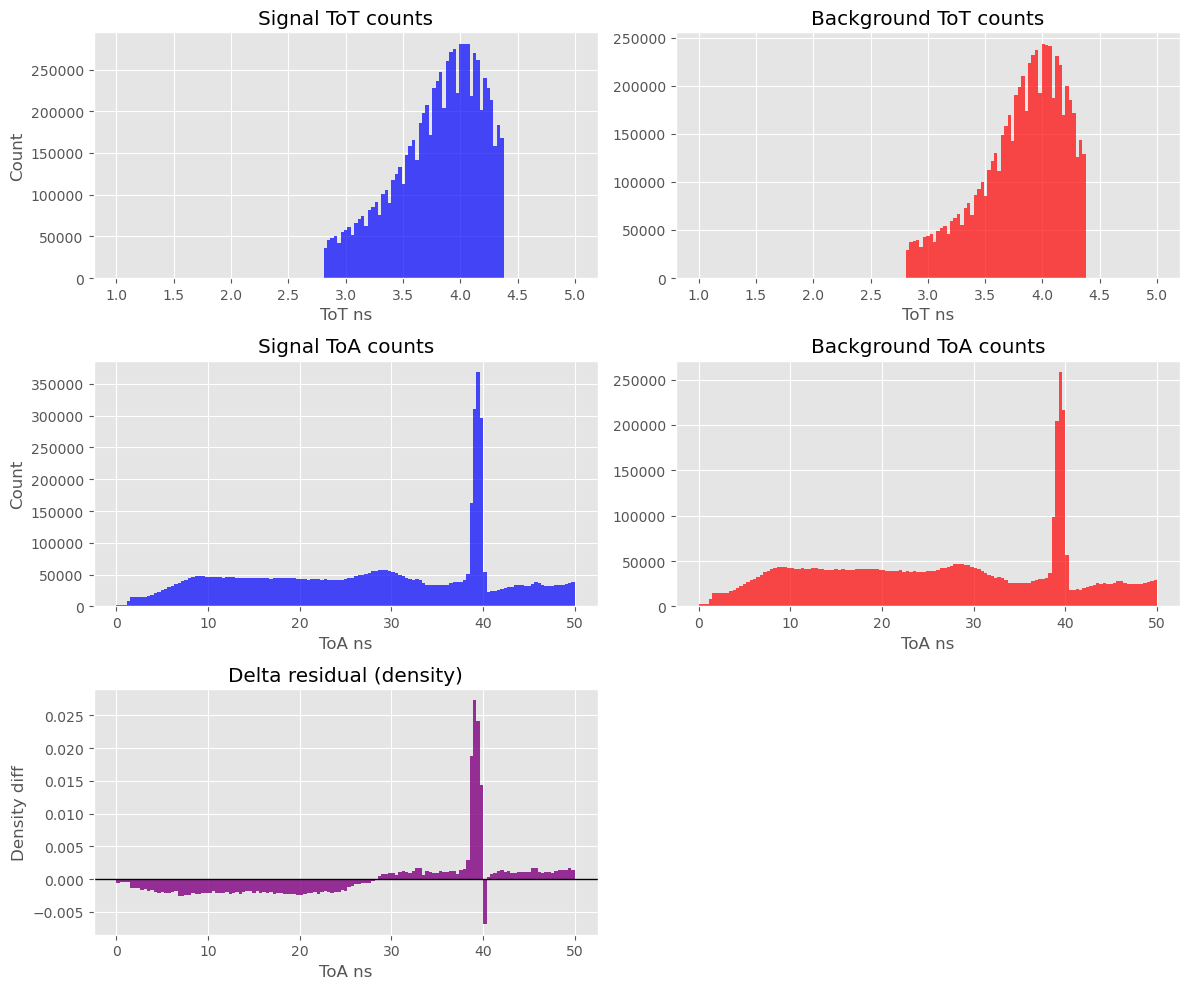

Histograms have been successfully created in 3.89s


In [28]:
test_bunching_histograms_parquet('data/test_signal_Run699_list.parquet', 'data/test_backgrnd_Run702_list.parquet')